In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

In [2]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
#Importing Libraries
import numpy as np
import pandas as pd

%matplotlib inline
from sklearn import metrics

In [5]:
# Set the random seed for reproducibility
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

In [6]:
# Read APPL.csv contains open, high, low, close, Adj close, Volume of Apple stock with twitter polarity scores and twitter volume
df = pd.read_csv('/content/drive/MyDrive/Futurense Hackaton/AAPL_sentiment.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)

# Drop null values
df.dropna(inplace=True)
df.tail()

,Open,High,Low,Close,Adj Close,Volume,ts_polarity,twitter_volume
Date,,,,,,,,
2019-08-26,51.47,51.80,51.26,51.62,51.12,104174400,0.072340,888.0
2019-08-27,51.97,52.14,50.88,51.04,50.54,103493200,0.117541,962.0
2019-08-28,51.03,51.43,50.83,51.38,50.88,63755200,0.061477,895.0
2019-08-29,52.13,52.33,51.67,52.25,51.74,83962000,0.056460,1083.0
2019-08-30,52.54,52.61,51.80,52.19,51.67,84573600,0.106096,1005.0


In [7]:
# Dataframe with Adj close, ts_polarity, twitter_volume of APPL
df = df[["Adj Close", "ts_polarity", "twitter_volume"]]
df.head()

,Adj Close,ts_polarity,twitter_volume
Date,,,
2016-01-04,24.44,0.070389,1133.0
2016-01-05,23.83,0.133635,1430.0
2016-01-06,23.36,0.072042,1949.0
2016-01-07,22.38,0.074369,2289.0
2016-01-08,22.50,0.051595,2235.0


In [8]:
# pct change based on Adj close value
df["Pct_change"] = df["Adj Close"].pct_change()

# Drop null values
df.dropna(inplace = True)
df.head()

,Adj Close,ts_polarity,twitter_volume,Pct_change
Date,,,,
2016-01-05,23.83,0.133635,1430.0,-0.024959
2016-01-06,23.36,0.072042,1949.0,-0.019723
2016-01-07,22.38,0.074369,2289.0,-0.041952
2016-01-08,22.50,0.051595,2235.0,0.005362
2016-01-11,22.86,0.019443,1222.0,0.016000


In [9]:
# This function "window_data" accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number):
    # Create empty lists "X_close", "X_polarity", "X_volume" and y
    X_close = []
    X_polarity = []
    X_volume = []
    y = []
    for i in range(len(df) - window):
        
        # Get close, ts_polarity, tw_vol, and target in the loop
        close = df.iloc[i:(i + window), feature_col_number1]
        ts_polarity = df.iloc[i:(i + window), feature_col_number2]
        tw_vol = df.iloc[i:(i + window), feature_col_number3]
        target = df.iloc[(i + window), target_col_number]
        
        # Append values in the lists
        X_close.append(close)
        X_polarity.append(ts_polarity)
        X_volume.append(tw_vol)
        y.append(target)
        
    return np.hstack((X_close,X_polarity,X_volume)), np.array(y).reshape(-1, 1)

In [10]:
# Predict Closing Prices using a 3 day window of previous closing prices
window_size = 3

# Column index 0 is the `Adj Close` column
# Column index 1 is the `ts_polarity` column
# Column index 2 is the `twitter_volume` column
feature_col_number1 = 0
feature_col_number2 = 1
feature_col_number3 = 2
target_col_number = 0
X, y = window_data(df, window_size, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)

In [11]:
# Use 70% of the data for training and the remaineder for testing
X_split = int(0.7 * len(X))
y_split = int(0.7 * len(y))

X_train = X[: X_split]
X_test = X[X_split:]
y_train = y[: y_split]
y_test = y[y_split:]

**Scaling Data**

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
# Use the MinMaxScaler to scale data between 0 and 1.
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

**Reshaping Data**

In [14]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [16]:
# Build the LSTM model. 

# Define the LSTM RNN model.
model = Sequential()

number_units = 9
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
    
model.add(Dropout(dropout_fraction))

# Layer 2
# The return_sequences parameter needs to set to True every time we add a new LSTM layer, excluding the final layer.
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [17]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [18]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 9, 9)              396       
                                                                 
 dropout (Dropout)           (None, 9, 9)              0         
                                                                 
 lstm_1 (LSTM)               (None, 9, 9)              684       
                                                                 
 dropout_1 (Dropout)         (None, 9, 9)              0         
                                                                 
 lstm_2 (LSTM)               (None, 9)                 684       
                                                                 
 dropout_2 (Dropout)         (None, 9)                 0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [19]:
# Train the model
model.fit(X_train, y_train, epochs=30, shuffle=False, batch_size=5, verbose=1)

Epoch 1/30
129/129 [==============================] - 11s 8ms/step - loss: 0.0167
Epoch 2/30
129/129 [==============================] - 1s 7ms/step - loss: 0.0529
Epoch 3/30
129/129 [==============================] - 1s 7ms/step - loss: 0.0460
Epoch 4/30
129/129 [==============================] - 1s 7ms/step - loss: 0.0350
Epoch 5/30
129/129 [==============================] - 1s 7ms/step - loss: 0.0242
Epoch 6/30
129/129 [==============================] - 1s 7ms/step - loss: 0.0157
Epoch 7/30
129/129 [==============================] - 1s 7ms/step - loss: 0.0108
Epoch 8/30
129/129 [==============================] - 1s 7ms/step - loss: 0.0111
Epoch 9/30
129/129 [==============================] - 1s 9ms/step - loss: 0.0099
Epoch 10/30
129/129 [==============================] - 1s 11ms/step - loss: 0.0092
Epoch 11/30
129/129 [==============================] - 1s 11ms/step - loss: 0.0084
Epoch 12/30
129/129 [==============================] - 1s 8ms/step - loss: 0.0063
Epoch 13/30
129/129 [=

In [20]:
# Evaluate the model for loss
model.evaluate(X_test, y_test)

9/9 [==============================] - 1s 6ms/step - loss: 0.0112


0.011154009029269218

In [21]:
# Make some predictions
predicted = model.predict(X_test)

9/9 [==============================] - 1s 4ms/step


In [22]:
# Evaluating the model
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))

Root Mean Squared Error: 0.10561253539039543
R-squared : 0.7994348108494701


In [23]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [24]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
Date,,
2018-07-27,46.39,50.465343
2018-07-30,46.13,48.947948
2018-07-31,46.22,49.604607
2018-08-01,48.95,48.516396
2018-08-02,50.38,49.428642


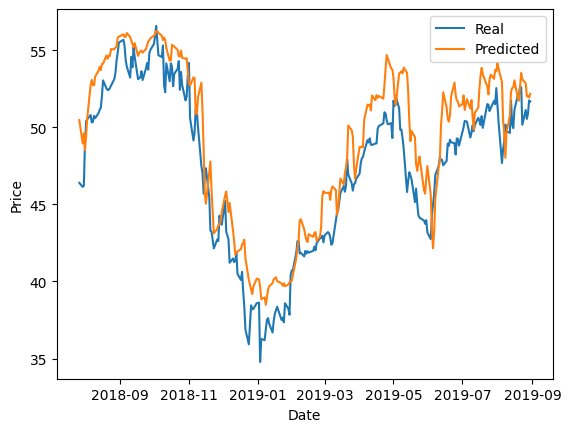

In [25]:
import matplotlib.pyplot as plt
plt.plot(stocks.index, stocks["Real"], label="Real")
plt.plot(stocks.index, stocks["Predicted"], label="Predicted")

# add axis labels and legend
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

# display the plot
plt.show()

In [26]:
import os
model.save(os.path.join('/content/drive/MyDrive/models','Apple_stock_market_model'))